In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

### Load Data

In [ ]:
import os
import zipfile

local_zip = './drive/MyDrive/Shenasa/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
try:
    os.mkdir('/tmp/Face_dataset')
    os.mkdir('/tmp/Face_dataset/training')
    os.mkdir('/tmp/Face_dataset/testing')

    os.mkdir('/tmp/Face_dataset/training/real')
    os.mkdir('/tmp/Face_dataset/training/fake')

    os.mkdir('/tmp/Face_dataset/testing/real')
    os.mkdir('/tmp/Face_dataset/testing/fake')

except OSError:
    pass

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


real_SOURCE_DIR = "/tmp/dataset/real/"
TRAINING_real_DIR = "/tmp/Face_dataset/training/real/"
TESTING_real_DIR = "/tmp/Face_dataset/testing/real/"

fake_SOURCE_DIR = "/tmp/dataset/fake/"
TRAINING_fake_DIR = "/tmp/Face_dataset/training/fake/"
TESTING_fake_DIR = "/tmp/Face_dataset/testing/fake/"

split_size = .9
split_data(real_SOURCE_DIR, TRAINING_real_DIR, TESTING_real_DIR, split_size)
split_data(fake_SOURCE_DIR, TRAINING_fake_DIR, TESTING_fake_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [ ]:
TRAINING_DIR = "/tmp/Face_dataset/training/"


train_datagen = ImageDataGenerator(rescale = 1.0/255., 
                                   rotation_range=20, 
                                   zoom_range=0.15,
	                                 width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.15,
	                                 horizontal_flip=True, 
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=8,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

VALIDATION_DIR = "/tmp/Face_dataset/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=8,
                                                              class_mode='categorical',
                                                              target_size=(300, 300))

Found 562 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


## Create and Trained Model

In [ ]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.InputLayer(input_shape=(300, 300, 3)),

    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0

In [ ]:
INIT_LR = 1e-4
BS = 8
EPOCHS = 50
trainX = len(os.listdir('/tmp/Face_dataset/training/real')) + len(os.listdir('/tmp/Face_dataset/training/fake')) 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=INIT_LR), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(train_generator ,epochs=50, steps_per_epoch=trainX // BS,
                    validation_data=validation_generator, validation_steps=1, callbacks=[early_stop])

Epoch 1/50
70/70 [==============================] - 44s 220ms/step - loss: 0.6777 - accuracy: 0.6101 - val_loss: 0.5684 - val_accuracy: 0.8750
Epoch 2/50
70/70 [==============================] - 15s 219ms/step - loss: 0.6255 - accuracy: 0.6715 - val_loss: 0.6441 - val_accuracy: 0.7500
Epoch 3/50
70/70 [==============================] - 15s 215ms/step - loss: 0.6057 - accuracy: 0.6877 - val_loss: 0.6305 - val_accuracy: 0.3750
Epoch 4/50
70/70 [==============================] - 15s 214ms/step - loss: 0.5659 - accuracy: 0.7238 - val_loss: 0.4950 - val_accuracy: 0.8750
Epoch 5/50
70/70 [==============================] - 15s 216ms/step - loss: 0.5268 - accuracy: 0.7256 - val_loss: 0.2844 - val_accuracy: 1.0000
Epoch 6/50
70/70 [==============================] - 15s 216ms/step - loss: 0.4641 - accuracy: 0.7780 - val_loss: 0.2479 - val_accuracy: 0.8750
Epoch 7/50
70/70 [==============================] - 15s 215ms/step - loss: 0.4306 - accuracy: 0.8032 - val_loss: 0.3343 - val_accuracy: 1.0000

In [ ]:
model.save('./drive/MyDrive/Shenasa/trained_model_1.h5')

<Figure size 432x288 with 0 Axes>

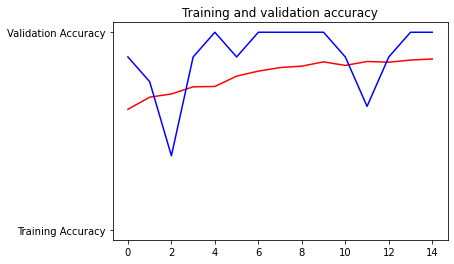

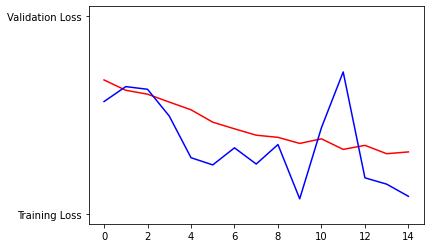

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


## Load and Evaluate Model

In [ ]:
# # Load Model
new_model=tf.keras.models.load_model('./drive/MyDrive/Shenasa/trained_model_1.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0

In [ ]:
loss, acc = new_model.evaluate(validation_generator, verbose=2)
print("model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 1s - loss: 0.4299 - accuracy: 0.8438
model, accuracy: 84.38%


## Label Encoder


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle

le = LabelEncoder()
labels = le.fit_transform(train_generator.labels)
labels = to_categorical(train_generator.labels, 2)

# save the label encoder to disk
f = open('le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()